In [56]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pyrosm
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import contextily as ctx
import pydeck as pdk

In [34]:
import sys
print(sys.executable)

/opt/homebrew/opt/python@3.11/bin/python3.11


Исходные данные

In [2]:
train_ros = pd.read_csv('train.csv', index_col=0)
test_ros = pd.read_csv('test.csv', index_col=0)

train_ros['isTrain'] = True
test_ros['isTrain'] = False

data = pd.concat([train_ros, test_ros], sort=False)

In [3]:
data.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True


Файл с данными OSM был скачен на сайте https://download.geofabrik.de/russia.html. После чего при помощи утилиты https://osmcode.org/osmium-tool/manual.html был очищен от лишней для нашей задачи информации — сохранил информацию о точках интереса

In [4]:
osm = pyrosm.OSM("filtered.osm.pbf")
pois = osm.get_pois()

/opt/homebrew/lib/python3.11/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/opt/homebrew/lib/python3.11/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/opt/homebrew/lib/python3.11/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [5]:
print(list(pois.columns))

['lon', 'timestamp', 'lat', 'tags', 'id', 'changeset', 'visible', 'version', 'addr:city', 'addr:country', 'addr:full', 'addr:housenumber', 'addr:housename', 'addr:postcode', 'addr:place', 'addr:street', 'email', 'name', 'opening_hours', 'operator', 'phone', 'ref', 'url', 'website', 'amenity', 'atm', 'bicycle_parking', 'bicycle_rental', 'bar', 'building', 'building:levels', 'cafe', 'car_repair', 'car_wash', 'charging_station', 'drinking_water', 'fast_food', 'fountain', 'fuel', 'hospital', 'ice_cream', 'internet_access', 'kindergarten', 'landuse', 'office', 'parking', 'school', 'social_facility', 'source', 'start_date', 'wikipedia', 'agrarian', 'alcohol', 'antiques', 'bakery', 'beverages', 'bicycle', 'books', 'butcher', 'car', 'car_parts', 'charity', 'chemist', 'clothes', 'coffee', 'collector', 'computer', 'craft', 'curtain', 'doityourself', 'dry_cleaning', 'fireplace', 'fishing', 'furniture', 'gift', 'hairdresser', 'hardware', 'interior_decoration', 'kiosk', 'laundry', 'leather', 'mall'

In [6]:
pois['amenity'].unique()

array([None, 'fuel', 'hospital', 'bank', 'school', 'atm', 'restaurant',
       'kindergarten', 'post_box', 'bus_station', 'parking', 'pharmacy',
       'cafe', 'fast_food', 'clinic', 'place_of_worship', 'fountain',
       'marketplace', 'ferry_terminal', 'car_wash', 'pub',
       'parking_entrance', 'gym', 'ice_cream', 'bench', 'boat_rental',
       'horse_rental', 'waste_disposal', 'doctors', 'police', 'photo',
       'veterinary', 'post_office', 'shelter', 'telephone',
       'compressed_air', 'bicycle_rental', 'clock', 'bar',
       'vending_machine', 'public_building', 'sanatorium', 'beauty',
       'waste_basket', 'tyres_repair', 'spa', 'university', 'photo_lab',
       'hunting_stand', 'driving_school', 'theatre', 'dentist',
       'arts_centre', 'public_bath', 'service', 'toilets',
       'social_facility', 'library', 'beauty_salon', 'photostudio',
       'grave_yard', 'taxi', 'biergarten', 'dancing_school',
       'drinking_water', 'car_sharing', 'training', 'veterinary_pharmac

Посмотрим на точки интереса вокруг банкомата в радиусе 100м

In [7]:
gdf_atm = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['long'], data['lat']),
    crs="EPSG:4326"
)

if 'geometry' not in pois.columns:
    pois = gpd.GeoDataFrame(
        pois,
        geometry=gpd.points_from_xy(pois['lon'], pois['lat']),
        crs="EPSG:4326"
    )

gdf_atm = gdf_atm.to_crs(epsg=3857)
pois = pois.to_crs(epsg=3857)

gdf_atm['buffer'] = gdf_atm.geometry.buffer(100)

gdf_atm_buffer = gdf_atm[['buffer']].copy().set_geometry('buffer')
print("CRS буферного GeoDataFrame:", gdf_atm_buffer.crs)

pois_in_buffer = gpd.sjoin(pois, gdf_atm_buffer, predicate='intersects', how='left')

poi_counts = pois_in_buffer.groupby('index_right').size().rename("poi_count")
gdf_atm = gdf_atm.join(poi_counts, how='left')
gdf_atm['poi_count'] = gdf_atm['poi_count'].fillna(0).astype(int)

poi_amenities = pois_in_buffer.groupby('index_right')['amenity'] \
    .apply(lambda x: list(x.dropna().unique())) \
    .rename("poi_amenities")
gdf_atm = gdf_atm.join(poi_amenities, how='left')

data_with_pois = gdf_atm.drop(columns=['geometry', 'buffer'])

CRS буферного GeoDataFrame: EPSG:3857


In [8]:
data_with_pois.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,poi_count,poi_amenities
0.0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,9,[]
1.0,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,7,"[bank, kindergarten]"
2.0,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,20,"[bank, atm]"
3.0,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,38,"[atm, bank, school, kindergarten]"
4.0,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,5,[bank]


Уникальные точки интереса

In [9]:
unique_amenities = set()
for amenities in data_with_pois['poi_amenities'].dropna():
    unique_amenities.update(amenities)

print(unique_amenities)

{'marketplace', 'fuel', 'charging_station', 'drinking_water', 'hospital', 'parking_entrance', 'post_box', 'townhall', 'loto', 'food_court', 'kindergarten', 'bar', 'sanatorium', 'vending_machine', 'cafe', 'fast_food', 'restaurant', 'bicycle_rental', 'pub', 'pharmacy', 'atm', 'photostudio', 'nightclub', 'sport', 'clock', 'loading_dock', 'community_centre', 'bank', 'pub;bar;restaurant', 'car_wash', 'post_office', 'public_bath', 'exhibition_centre', 'money_transfer', 'school', 'bus_station', 'parking', 'ice_cream'}


Посмотрим наличие каждого из объектов

In [10]:
amenities_to_check = {
    'hospital', 'nightclub', 'parking', 'post_office', 'pub;bar;restaurant', 
    'clock', 'bar', 'cafe', 'public_bath', 'photostudio', 'community_centre', 
    'post_box', 'restaurant', 'school', 'kindergarten', 'bus_station', 
    'marketplace', 'food_court', 'exhibition_centre', 'money_transfer', 
    'charging_station', 'car_wash', 'drinking_water', 'pub', 'ice_cream', 
    'bank', 'townhall', 'loto', 'vending_machine', 'bicycle_rental', 
    'loading_dock', 'fast_food', 'fuel', 'parking_entrance', 'atm', 'sport', 
    'sanatorium', 'pharmacy'
}

for amenity in amenities_to_check:
    gdf_atm[amenity + '_flag'] = gdf_atm['poi_amenities'].apply(
        lambda x: 1 if isinstance(x, list) and amenity in x else 0
    )

Посчитаем расстояние до ближайшего банкомата

In [11]:
valid_mask = (~gdf_atm.geometry.is_empty) & (gdf_atm.geometry.notnull())
valid_gdf_atm = gdf_atm[valid_mask].copy()

coords = np.array([(geom.x, geom.y) for geom in valid_gdf_atm.geometry])
tree = cKDTree(coords)

distances, indices = tree.query(coords, k=2)
nearest_distance = distances[:, 1]

valid_gdf_atm['nearest_atm_distance'] = nearest_distance

gdf_atm['nearest_atm_distance'] = np.nan
gdf_atm.loc[valid_mask, 'nearest_atm_distance'] = valid_gdf_atm['nearest_atm_distance']

data_with_pois = gdf_atm.copy()

/opt/homebrew/lib/python3.11/site-packages/geopandas/geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [12]:
pd.set_option('display.max_columns', None)

Добавим в явном виде город

In [13]:
address_parts = data_with_pois['address_rus'].str.split(',', expand=True)

data_with_pois['city'] = address_parts[2].str.strip() if address_parts.shape[1] > 2 else None

In [14]:
data_with_pois.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8765 entries, 0.0 to 2503.0
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       8765 non-null   float64 
 1   atm_group                8765 non-null   float64 
 2   address                  8765 non-null   object  
 3   address_rus              8345 non-null   object  
 4   lat                      8345 non-null   float64 
 5   long                     8345 non-null   float64 
 6   target                   6261 non-null   float64 
 7   isTrain                  8765 non-null   bool    
 8   geometry                 8765 non-null   geometry
 9   buffer                   8765 non-null   geometry
 10  poi_count                8765 non-null   int64   
 11  poi_amenities            7694 non-null   object  
 12  marketplace_flag         8765 non-null   int64   
 13  fuel_flag                8765 non-null   int64   
 14  c

In [15]:
city = pd.read_csv('city.csv', index_col=0)

city.head()

,Герб,Город,Регион,Федеральный округ,Население,Основание илипервое упоминание,Статус города[4],Прежние названия,City (Transliteration),Link
№,,,,,,,,,,
1,NaN,Абаза,Хакасия,Сибирский,12272,1867,1966,"Абаканский Завод, Абаканско-Заводское",Abaza,https://mainfin.ru/banki/poisk/bankomaty/abaza
2,NaN,Абакан,Хакасия,Сибирский,184769,1734,1931,Усть-Абаканское (до 1931),Abakan,https://mainfin.ru/banki/poisk/bankomaty/abakan
3,NaN,Абдулино,Оренбургская область,Приволжский,17274,1795,1923,NaN,Abdulino,https://mainfin.ru/banki/poisk/bankomaty/abdulino
4,NaN,Абинск,Краснодарский край,Южный,39511,1863,1963,Абинское (до 1863);Абинская (до 1962),Abinsk,https://mainfin.ru/banki/poisk/bankomaty/abinsk
5,NaN,Агидель,Башкортостан,Приволжский,14219,1980,1991,NaN,Agidel,https://mainfin.ru/banki/poisk/bankomaty/agidel


Добавим информацию о населении, если пункта нет в списке городов, значит это деревня и поселок, укажем наседение для таких пунктов 1000

In [16]:
city = pd.read_csv('city.csv', index_col=0)
print("Столбцы в city:", city.columns.tolist())

city_columns = ['Город', 'Население']

df = pd.merge(
    data_with_pois,
    city[['Город', 'Население']],
    how='left',
    left_on='city',
    right_on='Город'
)

print("После merge, столбцы:", df.columns.tolist())

if 'Население' in df.columns:
    df.rename(columns={'Население': 'population'}, inplace=True)
else:
    df['population'] = 1000 

df['population'] = df['population'].fillna(1000)

df.drop(columns=['Город'], inplace=True)

Столбцы в city: ['Герб', 'Город', 'Регион', 'Федеральный округ', 'Население', 'Основание илипервое упоминание', 'Статус города[4]', 'Прежние названия', 'City (Transliteration)', 'Link']
После merge, столбцы: ['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target', 'isTrain', 'geometry', 'buffer', 'poi_count', 'poi_amenities', 'marketplace_flag', 'fuel_flag', 'charging_station_flag', 'drinking_water_flag', 'hospital_flag', 'parking_entrance_flag', 'townhall_flag', 'post_box_flag', 'loto_flag', 'food_court_flag', 'bar_flag', 'kindergarten_flag', 'sanatorium_flag', 'vending_machine_flag', 'cafe_flag', 'fast_food_flag', 'restaurant_flag', 'bicycle_rental_flag', 'pub_flag', 'pharmacy_flag', 'atm_flag', 'photostudio_flag', 'nightclub_flag', 'sport_flag', 'clock_flag', 'loading_dock_flag', 'community_centre_flag', 'bank_flag', 'pub;bar;restaurant_flag', 'car_wash_flag', 'post_office_flag', 'public_bath_flag', 'exhibition_centre_flag', 'money_transfer_flag', 'school_flag', 'bus_s

In [17]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       8902 non-null   float64 
 1   atm_group                8902 non-null   float64 
 2   address                  8902 non-null   object  
 3   address_rus              8482 non-null   object  
 4   lat                      8482 non-null   float64 
 5   long                     8482 non-null   float64 
 6   target                   6358 non-null   float64 
 7   isTrain                  8902 non-null   bool    
 8   geometry                 8902 non-null   geometry
 9   buffer                   8902 non-null   geometry
 10  poi_count                8902 non-null   int64   
 11  poi_amenities            7814 non-null   object  
 12  marketplace_flag         8902 non-null   int64   
 13  fuel_flag                8902 non-null   int64   
 14  

In [18]:
df.to_csv("Final_df.csv", index=False)

Базовая аналитика

In [19]:
(df.describe(include='all'))

,id,atm_group,address,address_rus,lat,long,target,isTrain,geometry,buffer,poi_count,poi_amenities,marketplace_flag,fuel_flag,charging_station_flag,drinking_water_flag,hospital_flag,parking_entrance_flag,townhall_flag,post_box_flag,loto_flag,food_court_flag,bar_flag,kindergarten_flag,sanatorium_flag,vending_machine_flag,cafe_flag,fast_food_flag,restaurant_flag,bicycle_rental_flag,pub_flag,pharmacy_flag,atm_flag,photostudio_flag,nightclub_flag,sport_flag,clock_flag,loading_dock_flag,community_centre_flag,bank_flag,pub;bar;restaurant_flag,car_wash_flag,post_office_flag,public_bath_flag,exhibition_centre_flag,money_transfer_flag,school_flag,bus_station_flag,parking_flag,ice_cream_flag,nearest_atm_distance,city,population
count,8902.000000,8902.000000,8902,8482,8482.000000,8482.000000,6358.000000,8902,8902,8902,8902.000000,7814,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8.482000e+03,8482,8.902000e+03
unique,NaN,NaN,7481,6147,NaN,NaN,NaN,2,6148,6148,NaN,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1156,NaN
top,NaN,NaN,"D. 50, PR-KT OKTYABR'SKII KIROV G","квартал В-13, городской округ Волгодонск, Рост...",NaN,NaN,NaN,True,POINT EMPTY,POLYGON EMPTY,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Москва,NaN
freq,NaN,NaN,8,10,NaN,NaN,NaN,6358,420,420,NaN,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776,NaN
mean,4418.083184,4415.514379,NaN,NaN,54.132196,63.844975,0.000637,NaN,NaN,NaN,8.105482,NaN,0.002022,0.000674,0.000112,0.000449,0.032802,0.004943,0.000225,0.000225,0.000449,0.000225,0.001685,0.062121,0.000562,0.000112,0.021905,0.004493,0.000449,0.000562,0.000562,0.002471,0.386542,0.000225,0.000112,0.000337,0.000899,0.000674,0.000225,0.373399,0.000449,0.000225,0.000225,0.000112,0.000225,0.000225,0.064929,0.009436,0.001236,0.003819,5.157328e+03,NaN,1.187005e+07
std,2537.554014,2425.580709,NaN,NaN,4.336124,33.008975,0.085853,NaN,NaN,NaN,10.071210,NaN,0.044924,0.025954,0.010599,0.021194,0.178127,0.070134,0.014988,0.014988,0.021194,0.014988,0.041017,0.241389,0.023694,0.010599,0.146382,0.066886,0.021194,0.023694,0.023694,0.049654,0.486985,0.014988,0.010599,0.018356,0.029966,0.025954,0.014988,0.483734,0.021194,0.014988,0.014988,0.010599,0.014988,0.014988,0.246415,0.096686,0.035132,0.061686,4.260047e+04,NaN,3.655040e+07
min,1.000000,32.000000,NaN,NaN,42.057080,19.941530,-0.145001,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,1.000000e+03
25%,2233.250000,1942.000000,NaN,NaN,52.068201,37.869044,-0.061290,NaN,NaN,NaN,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,3.975050e+04
50%,4424.500000,5478.000000,NaN,NaN,55.059758,49.137298,-0.015681,NaN,NaN,NaN

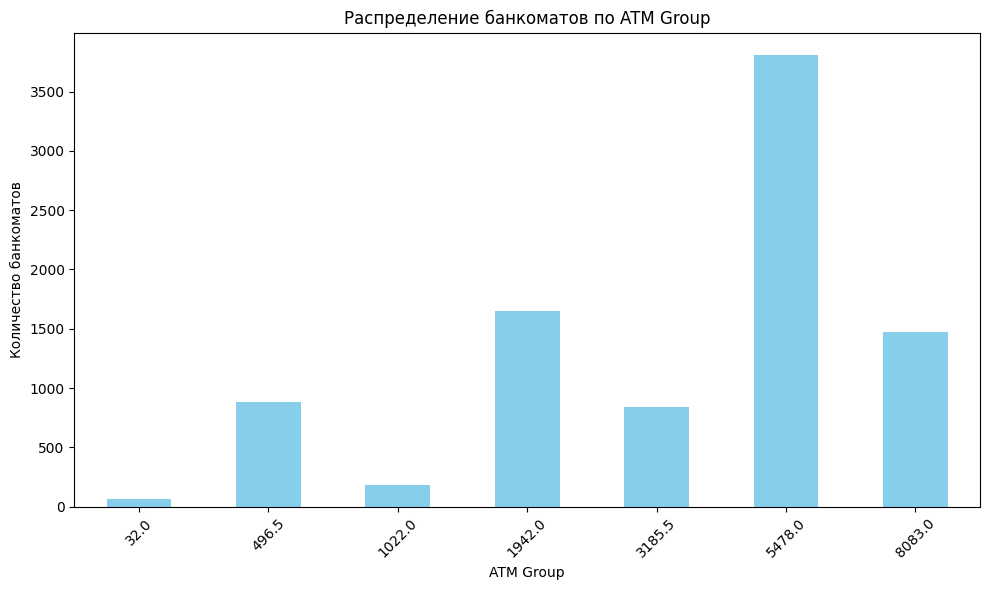

In [20]:
atm_group_counts = df['atm_group'].value_counts().sort_index()

# Строим столбчатую диаграмму
plt.figure(figsize=(10,6))
atm_group_counts.plot(kind='bar', color='skyblue')
plt.title("Распределение банкоматов по ATM Group")
plt.xlabel("ATM Group")
plt.ylabel("Количество банкоматов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

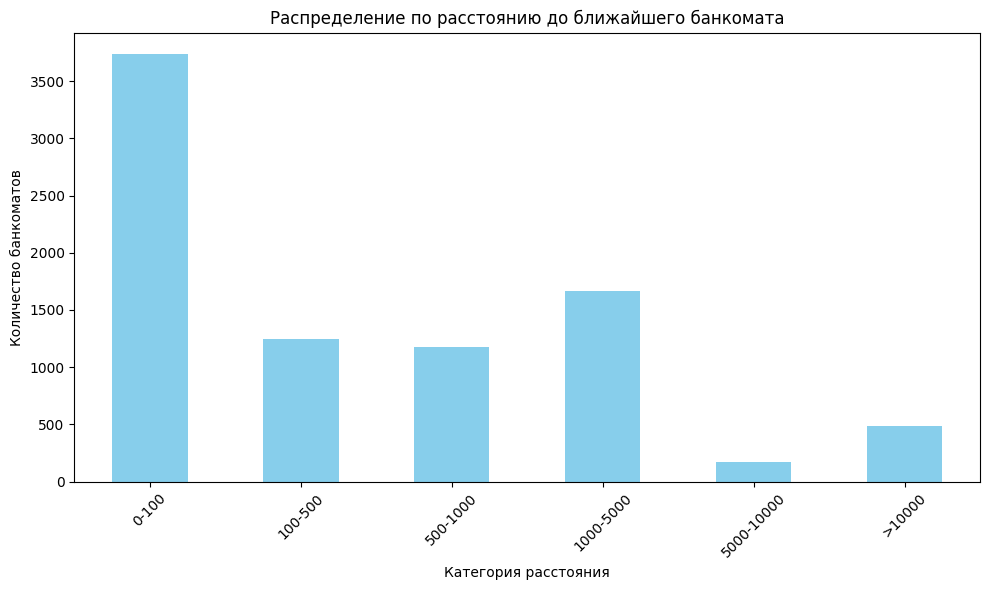

In [21]:
bins = [0, 100, 500, 1000, 5000, 10000, np.inf]
labels = ["0-100", "100-500", "500-1000", "1000-5000", "5000-10000", ">10000"]

df['distance_category'] = pd.cut(df['nearest_atm_distance'], bins=bins, labels=labels, include_lowest=True)

distance_dist = df['distance_category'].value_counts().sort_index()

plt.figure(figsize=(10,6))
distance_dist.plot(kind='bar', color='skyblue')
plt.title("Распределение по расстоянию до ближайшего банкомата")
plt.xlabel("Категория расстояния")
plt.ylabel("Количество банкоматов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

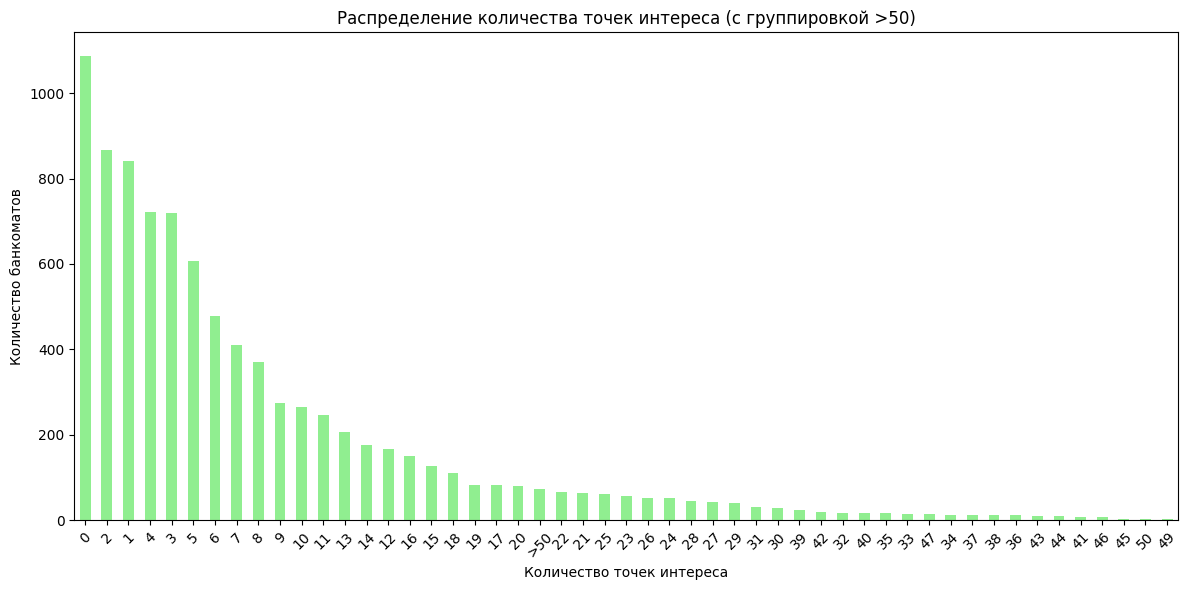

In [23]:
df['poi_count_category'] = df['poi_count'].apply(lambda x: x if x <= 50 else '>50')

poi_count_dist = df['poi_count_category'].value_counts()

plt.figure(figsize=(12, 6))
poi_count_dist.plot(kind='bar', color='lightgreen')
plt.title("Распределение количества точек интереса (с группировкой >50)")
plt.xlabel("Количество точек интереса")
plt.ylabel("Количество банкоматов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


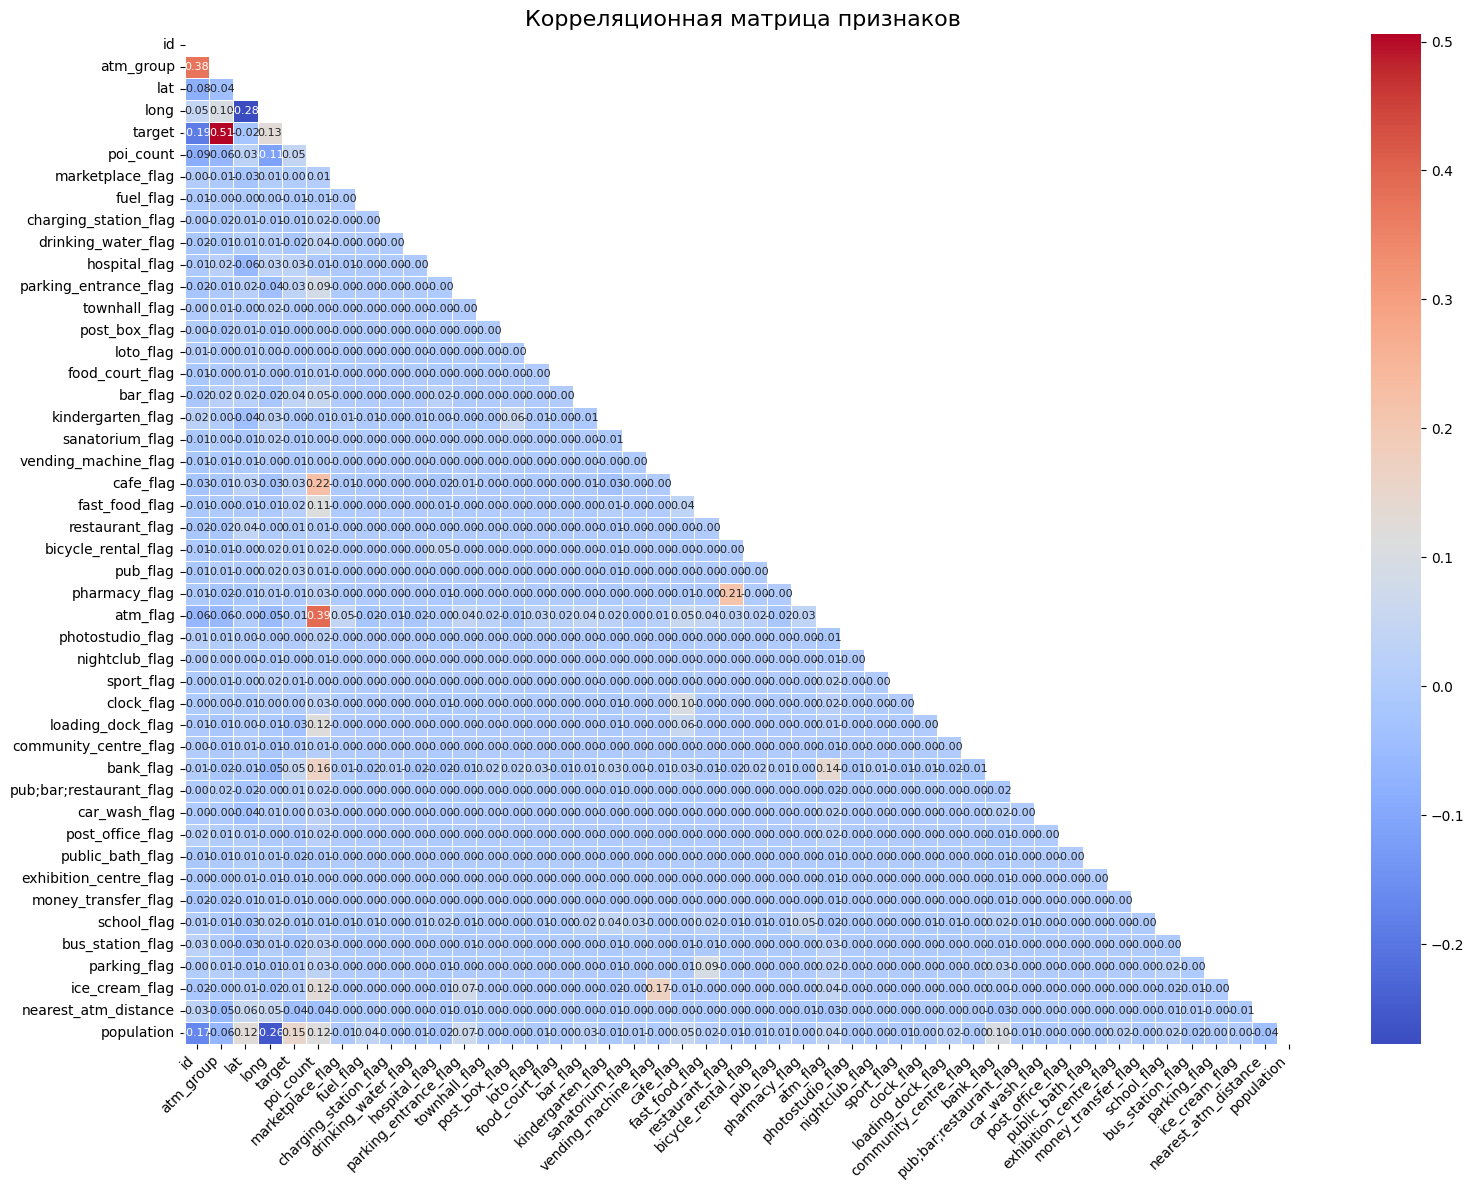

In [24]:
numerical_columns = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_columns.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            annot_kws={"size": 8}, linewidths=0.5)
plt.title("Корреляционная матрица признаков", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [25]:
target_correlation = correlation_matrix['target'].sort_values(ascending=False)
print("Корреляции с целевой переменной (target):\n", target_correlation)

Корреляции с целевой переменной (target):
 target                     1.000000
atm_group                  0.505588
population                 0.150151
long                       0.126502
bank_flag                  0.050687
poi_count                  0.046421
bar_flag                   0.037630
parking_entrance_flag      0.034189
hospital_flag              0.031844
pub_flag                   0.028075
cafe_flag                  0.025336
fast_food_flag             0.015043
pub;bar;restaurant_flag    0.012203
ice_cream_flag             0.011879
parking_flag               0.009992
sport_flag                 0.007368
restaurant_flag            0.006471
bicycle_rental_flag        0.005972
car_wash_flag              0.003839
marketplace_flag           0.001102
clock_flag                 0.000614
townhall_flag             -0.000323
loto_flag                 -0.000388
photostudio_flag          -0.001527
kindergarten_flag         -0.002036
nightclub_flag            -0.004414
post_box_flag        

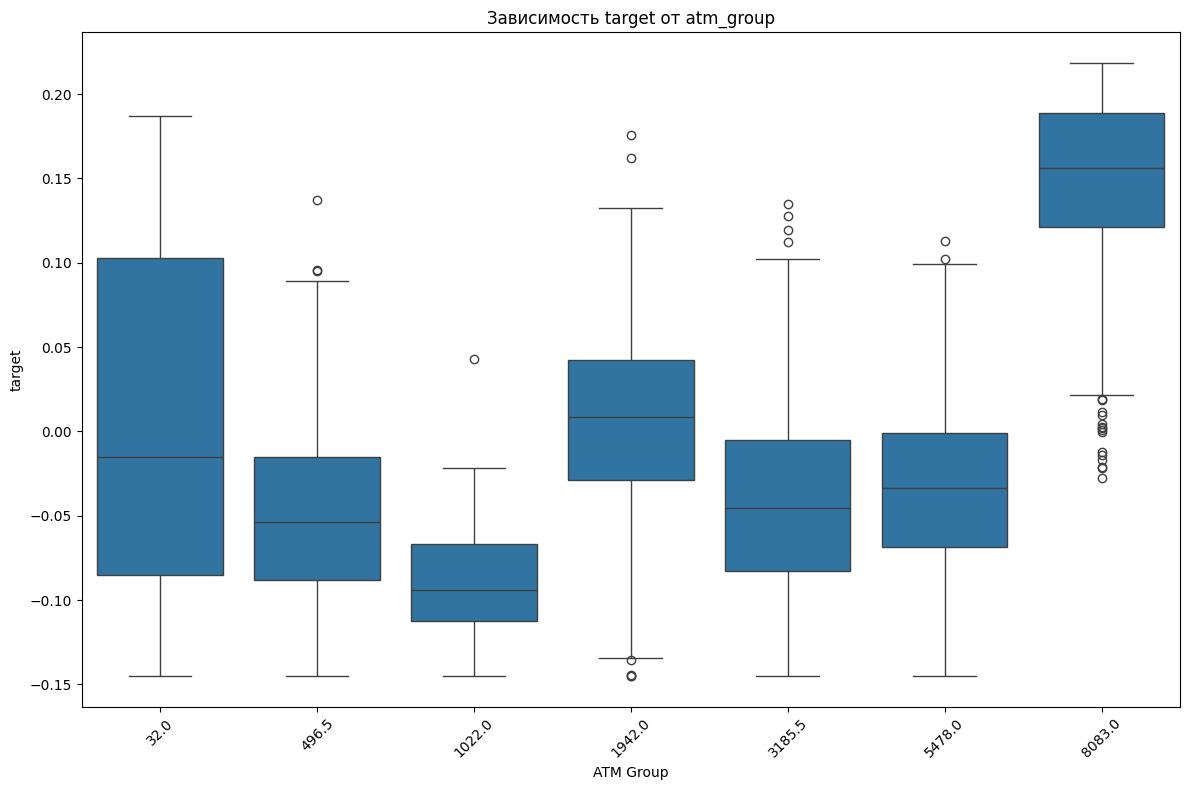

In [40]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="atm_group", y="target", data=df)
plt.title("Зависимость target от atm_group")
plt.xlabel("ATM Group")
plt.ylabel("target")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Корреляция между количеством банкоматов и средним target: 0.3649150743223


/var/folders/gk/x3lybh1s1v180w77tpp266sr0000gn/T/ipykernel_28920/488814823.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_stats, x='city', y='count_atm', palette='Blues', ax=ax1)


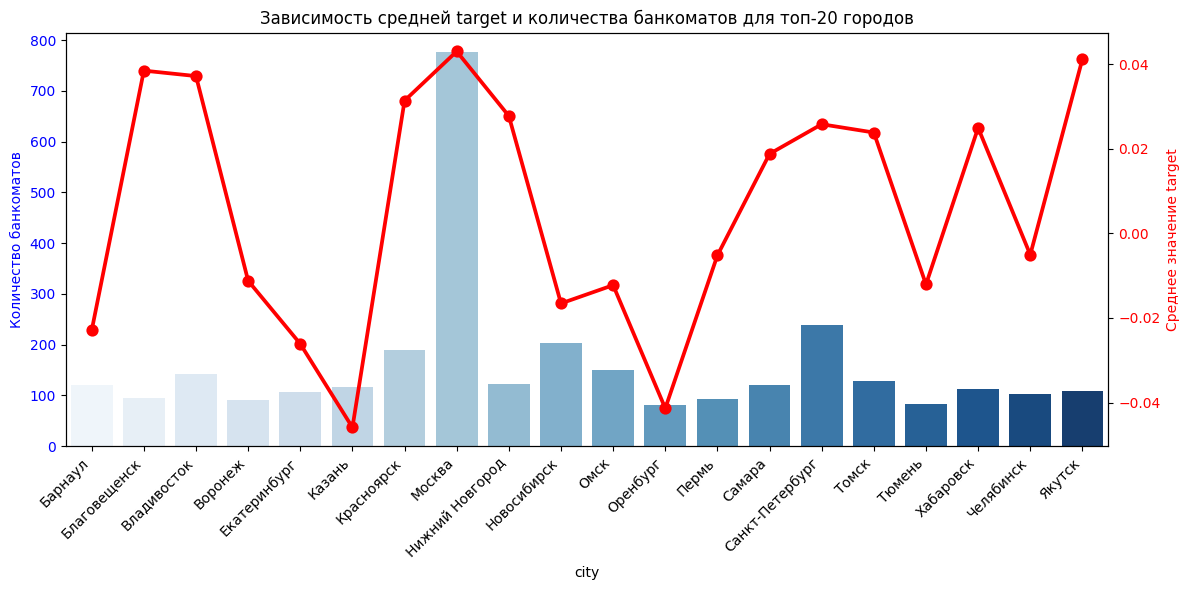

In [43]:
top20_cities = df['city'].value_counts().head(20).index
top20_df = df[df['city'].isin(top20_cities)]

city_stats = top20_df.groupby('city').agg(
    count_atm=('id', 'count'),
    avg_target=('target', 'mean')
).reset_index()

correlation = city_stats['count_atm'].corr(city_stats['avg_target'])
print("Корреляция между количеством банкоматов и средним target:", correlation)

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
sns.barplot(data=city_stats, x='city', y='count_atm', palette='Blues', ax=ax1)
ax1.set_ylabel("Количество банкоматов", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
sns.pointplot(data=city_stats, x='city', y='avg_target', color='red', ax=ax2)
ax2.set_ylabel("Среднее значение target", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Зависимость средней target и количества банкоматов для топ-20 городов")
plt.tight_layout()
plt.show()

/var/folders/gk/x3lybh1s1v180w77tpp266sr0000gn/T/ipykernel_28920/948607902.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20.index, y=top20.values, palette='viridis')


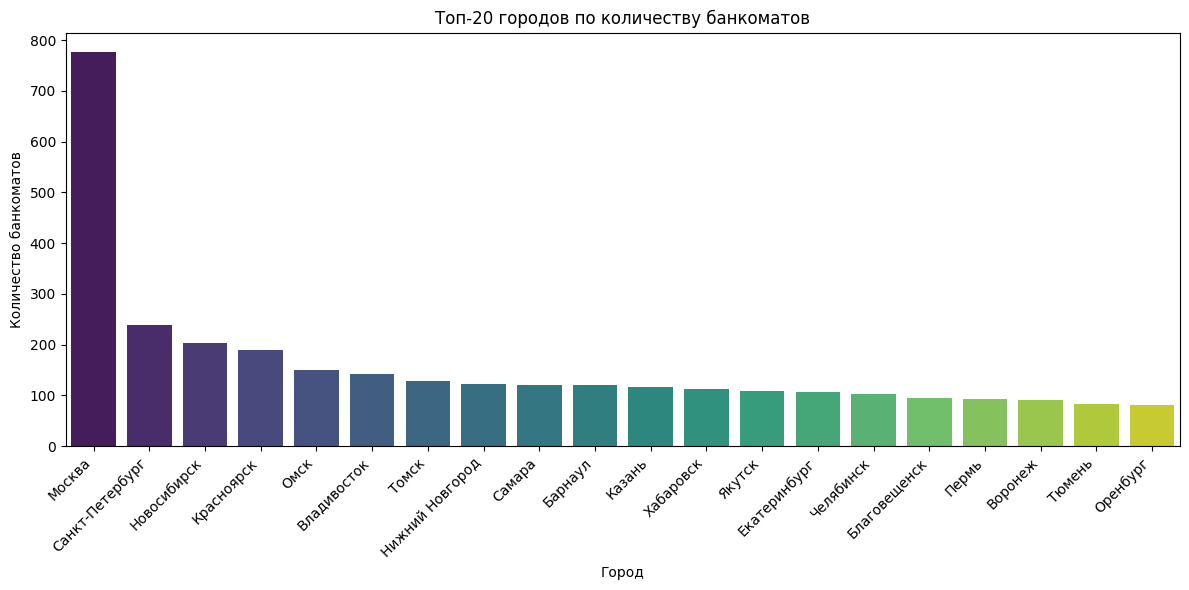

In [41]:
plt.figure(figsize=(12, 6))
top20 = df['city'].value_counts().head(20)
sns.barplot(x=top20.index, y=top20.values, palette='viridis')
plt.title("Топ-20 городов по количеству банкоматов")
plt.xlabel("Город")
plt.ylabel("Количество банкоматов")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

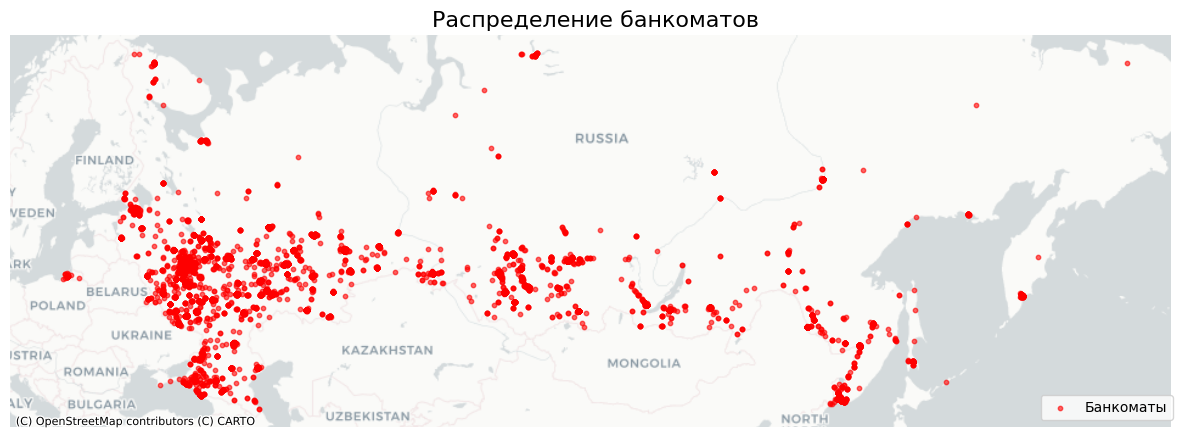

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))

df.plot(ax=ax, markersize=10, color='red', alpha=0.6, label='Банкоматы')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Распределение банкоматов", fontsize=16)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
city_counts = df.groupby('city').agg({
    'lat': 'mean',
    'long': 'mean',
    'id': 'count'
}).rename(columns={'id': 'atm_count'}).reset_index()

layer = pdk.Layer(
    "ScatterplotLayer",
    data=city_counts,
    get_position='[long, lat]',
    get_color='[200, 30, 0, 160]',
    get_radius='atm_count * 500',
    pickable=True
)

view_state = pdk.ViewState(
    latitude=city_counts['lat'].mean(),
    longitude=city_counts['long'].mean(),
    zoom=4,
    pitch=0,
)

r = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    tooltip={"text": "Город: {city}\nБанкоматов: {atm_count}"}
)

r

{
  "initialViewState": {
    "latitude": 53.66211637468981,
    "longitude": 62.183356982046305,
    "pitch": 0,
    "zoom": 4
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "atm_count": 2,
          "city": "1",
          "lat": 55.7423395,
          "long": 37.6960045
        },
        {
          "atm_count": 1,
          "city": "1-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "lat": 48.454135,
          "long": 135.116815
        },
        {
          "atm_count": 1,
          "city": "19-\u0439 \u043a\u0432\u0430\u0440\u0442\u0430\u043b",
          "lat": 53.547622,
          "long": 49.339203
        },
        {
          "atm_count": 1,
          "city": "2-\u0439 \u043a\u043e\u043c\u043f\u043b\u0435\u043a\u0441",
          "lat": 55.744895,
          "long": 52.421305
        },
        {
          "atm_count": 1,
          "city": "2-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "lat": 50.30109,
          "long": 127.521837
        },
        {
          "atm_count": 1,
          "city": "22-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "lat": 48.770869,
          "long": 44.806529
        },
        {
          "atm_count": 1,
          "city": "2\u0410",
          "lat": 55.717163,
          "long": 37.38216
        },
        {
          "atm_count": 1,
          "city": "4\u04411",
          "lat": 55.629394,
          "long": 37.308965
        },
        {
          "atm_count": 2,
          "city": "5",
          "lat": 53.325718,
          "long": 50.305359
        },
        {
          "atm_count": 1,
          "city": "6-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "lat": 55.002516,
          "long": 73.288172
        },
        {
          "atm_count": 1,
          "city": "7",
          "lat": 55.876476,
          "long": 37.422279
        },
        {
          "atm_count": 1,
          "city": "9-\u0439 \u043a\u0432\u0430\u0440\u0442\u0430\u043b",
          "lat": 53.520413,
          "long": 49.303046
        },
        {
          "atm_count": 27,
          "city": "\u0410\u0431\u0430\u043a\u0430\u043d",
          "lat": 53.72005355555556,
          "long": 91.43348955555555
        },
        {
          "atm_count": 1,
          "city": "\u0410\u0434\u043b\u0435\u0440\u0441\u043a\u0438\u0439 \u0440\u0430\u0439\u043e\u043d",
          "lat": 43.43831,
          "long": 39.912211
        },
        {
          "atm_count": 3,
          "city": "\u0410\u0437\u043e\u0432",
          "lat": 47.093358333333335,
          "long": 39.414305000000006
        },
        {
          "atm_count": 2,
          "city": "\u0410\u043a-\u0414\u043e\u0432\u0443\u0440\u0430\u043a",
          "lat": 51.183537,
          "long": 90.599772
        },
        {
          "atm_count": 5,
          "city": "\u0410\u043a\u0441\u0430\u0439",
          "lat": 47.286721799999995,
          "long": 39.852178200000004
        },
        {
          "atm_count": 3,
          "city": "\u0410\u043b\u0434\u0430\u043d",
          "lat": 58.60954866666666,
          "long": 125.38714366666666
        },
        {
          "atm_count": 3,
          "city": "\u0410\u043b\u0435\u0439\u0441\u043a",
          "lat": 52.495602999999996,
          "long": 82.77279466666666
        },
        {
          "atm_count": 2,
          "city": "\u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432",
          "lat": 56.3962615,
          "long": 38.70722
        },
        {
          "atm_count": 6,
          "city": "\u0410\u043b\u0435\u043a\u0441\u0438\u043d",
          "lat": 54.508491166666666,
          "long": 37.08587
        },
        {
          "atm_count": 3,
          "city": "\u0410\u043b\u0442\u0430\u0439\u0441\u043a\u0438\u0439 \u043a\u0440\u0430\u0439",
          "lat": 53.29968433333334,
          "long": 85.01383966666667
      

In [74]:
st.title("Связь городов и target на карте")

city_data = df.groupby("city").agg({
    "lat": "mean",
    "long": "mean",
    "target": "mean"
}).reset_index().rename(columns={"target": "avg_target"})

st.write("Данные по городам", city_data)

min_target = city_data["avg_target"].min()
max_target = city_data["avg_target"].max()

def map_target_to_color(avg_target):
    if pd.isna(avg_target):
        return [200, 200, 200, 160]
    ratio = (avg_target - min_target) / (max_target - min_target) if max_target != min_target else 0.5
    r = int(255 * ratio)
    g = int(255 * (1 - ratio))
    b = 0
    return [r, g, b, 160]

city_data["color"] = city_data["avg_target"].apply(map_target_to_color)

layer = pdk.Layer(
    "ScatterplotLayer",
    data=city_data,
    get_position='[long, lat]',
    get_color="color",
    get_radius=5000,
    pickable=True,
)

view_state = pdk.ViewState(
    latitude=city_data["lat"].mean(),
    longitude=city_data["long"].mean(),
    zoom=4,
    pitch=0,
)

deck = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    tooltip={"text": "Город: {city}\nAvg Target: {avg_target}"}
)

st.pydeck_chart(deck)

deck


2025-02-23 23:03:16.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.821 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.837 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-23 23:03:16.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

{
  "initialViewState": {
    "latitude": 53.66211637468981,
    "longitude": 62.183356982046305,
    "pitch": 0,
    "zoom": 4
  },
  "layers": [
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "avg_target": -0.0227498497197896,
          "city": "1",
          "color": [
            85,
            169,
            0,
            160
          ],
          "lat": 55.7423395,
          "long": 37.6960045
        },
        {
          "avg_target": NaN,
          "city": "1-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "color": [
            200,
            200,
            200,
            160
          ],
          "lat": 48.454135,
          "long": 135.116815
        },
        {
          "avg_target": -0.0472172007377128,
          "city": "19-\u0439 \u043a\u0432\u0430\u0440\u0442\u0430\u043b",
          "color": [
            68,
            186,
            0,
            160
          ],
          "lat": 53.547622,
          "long": 49.339203
        },
        {
          "avg_target": -0.0415239868681594,
          "city": "2-\u0439 \u043a\u043e\u043c\u043f\u043b\u0435\u043a\u0441",
          "color": [
            72,
            182,
            0,
            160
          ],
          "lat": 55.744895,
          "long": 52.421305
        },
        {
          "avg_target": 0.0081843828748439,
          "city": "2-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "color": [
            107,
            147,
            0,
            160
          ],
          "lat": 50.30109,
          "long": 127.521837
        },
        {
          "avg_target": NaN,
          "city": "22-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "color": [
            200,
            200,
            200,
            160
          ],
          "lat": 48.770869,
          "long": 44.806529
        },
        {
          "avg_target": 0.042213203847607,
          "city": "2\u0410",
          "color": [
            131,
            123,
            0,
            160
          ],
          "lat": 55.717163,
          "long": 37.38216
        },
        {
          "avg_target": 0.1547306509629538,
          "city": "4\u04411",
          "color": [
            210,
            44,
            0,
            160
          ],
          "lat": 55.629394,
          "long": 37.308965
        },
        {
          "avg_target": 0.12334399767017695,
          "city": "5",
          "color": [
            188,
            66,
            0,
            160
          ],
          "lat": 53.325718,
          "long": 50.305359
        },
        {
          "avg_target": -0.0771162307536436,
          "city": "6-\u0439 \u043c\u0438\u043a\u0440\u043e\u0440\u0430\u0439\u043e\u043d",
          "color": [
            47,
            207,
            0,
            160
          ],
          "lat": 55.002516,
          "long": 73.288172
        },
        {
          "avg_target": 0.0215469711134,
          "city": "7",
          "color": [
            116,
            138,
            0,
            160
          ],
          "lat": 55.876476,
          "long": 37.422279
        },
        {
          "avg_target": -0.0750507100813667,
          "city": "9-\u0439 \u043a\u0432\u0430\u0440\u0442\u0430\u043b",
          "color": [
            49,
            205,
            0,
            160
          ],
          "lat": 53.520413,
          "long": 49.303046
        },
        {
          "avg_target": 0.08463762933595555,
          "city": "\u0410\u0431\u0430\u043a\u0430\u043d",
          "color": [
            161,
            93,
            0,
            160
          ],
          "lat": 53.72005355555556,
          "long": 91.43348955555555
        },
        {
          "avg_target": NaN,
          "city": "\u0410\u0434\u043b\u0435\u0440\u0441\u043a\u0438\u0439 \u0440\u0430\u0439\u043e\u043d",
          "color": [
    